# SmolCDE

A small library for conditional density estimation using masked
autoregressive flows, with Python & C implementations and a small
CLI.

## Setup

The CLI/C implementation, is usable from source via clone repo & `cmake . && make`, otherwise download from [releases on GitHub](https://github.com/maedoc/smolcde/releases), where binaries for each platform are available.

The Python implementation depends on numpy, scipy and autograd only, making it easy to just drop the file `cde.py` into your project. 

You can run the tests with Python
```
uv venv env; . env/bin/activate
uv pip install pytest scipy autograd scikit_learn tqdm
pytest
```

## CLI

The CLI provides a CSV-based API for training MAFs for CDE and doing inference:

In [13]:
!./smolcde --help

Usage: smolcde <command> [options]

Commands:
  train      Train a MAF model from CSV data
  infer      Run inference using a trained model

Run 'smolcde <command> --help' for command-specific help.


In [14]:
!./smolcde train --help

Usage: smolcde train [options]

Options:
  --features <file>    CSV file with feature data (required)
  --params <file>      CSV file with target parameter data (required)
  --out <file>         Output model file (default: model.maf)
  --load <file>        Load initial model weights from file
  --hidden <int>       Hidden units per layer (default: 16)
  --blocks <int>       Number of flow blocks (default: 5)
  --epochs <int>       Training epochs (default: 100)
  --lr <float>         Learning rate (default: 0.001)
  --batch <int>        Batch size (default: 32)
  --skip-header        Skip first line of CSV files


In [15]:
!./smolcde infer --help

Usage: smolcde infer [options]

Options:
  --model <file>       Path to trained model file (required)
  --features <file>    CSV file with feature data (required)
  --out <file>         Output CSV file (default: out.csv)
  --samples <int>      Number of samples per feature row (default: 8)
  --mode <string>      Inference mode: 'sample', 'stats', 'quantiles' (default: sample)
  --quantiles-list <str> Comma-separated list of quantiles (default: 0.05,0.5,0.95)
  --skip-header        Skip first line of feature CSV


## Python API

The `cde.py` module exposes a single class supporting a similar train & infer workflow,

In [17]:
import cde
cde.MAFEstimator?

Init signature:
cde.MAFEstimator(
    param_dim: int,
    feature_dim: int,
    n_flows: int = 4,
    hidden_units: int = 64,
) -> None
Docstring:     
Masked Autoregressive Flow for conditional density estimation.

Parameters
----------
param_dim : int
    Dimensionality of the target variable.
feature_dim : int
    Dimensionality of the conditional variable.
n_flows : int, optional
    The number of flow layers (MADE blocks).
hidden_units : int, optional
    The number of hidden units in each MADE block.
File:           ~/src/smolcde/cde.py
Type:           ABCMeta
Subclasses:     NSFEstimator

In [18]:
cde.MAFEstimator.train?

Signature:
cde.MAFEstimator.train(
    self,
    params: numpy.ndarray,
    features: numpy.ndarray,
    batch_size: int = 32,
    train_ratio: float = 0.8,
    n_epochs: int = 100,
    learning_rate: float = 0.001,
    seed: int = 0,
    use_tqdm: bool = True,
)
Docstring: Trains the model using Adam with mini-batches and validation.
File:      ~/src/smolcde/cde.py
Type:      function

In [19]:
cde.MAFEstimator.sample?

Signature:
cde.MAFEstimator.sample(
    self,
    features: numpy.ndarray,
    n_samples: int,
    rng: numpy.random.mtrand.RandomState,
) -> numpy.ndarray
Docstring:
Generate samples from the learned conditional distribution p(params|features).

Parameters
----------
features : anp.ndarray
    A (n_conditions, feature_dim) array of features to condition on.
n_samples : int
    The number of samples to generate for each condition.
rng : autograd.numpy.random.RandomState
    A random number generator for sampling.

Returns
-------
anp.ndarray
    An array of generated samples of shape (n_conditions, n_samples, param_dim).
File:      ~/src/smolcde/cde.py
Type:      function

## Examples

We will cover two examples:
1. **Lorenz System Parameter Recovery**: Estimating parameters of a chaotic ODE from its trajectory.
2. **MNIST Digits**: "Estimating" the digit class from pixel values (treated as a regression problem).

In [1]:
# most deps here are just for testing/demo purposes
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('jpeg')
import os
import subprocess
from scipy.integrate import odeint
from scipy.signal import welch
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import autograd.numpy as anp

from cde import MAFEstimator

os.makedirs("tutorial_output", exist_ok=True)

/home/duke/src/smolcde/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Lorenz Parameter Recovery

The Lorenz system is defined by three parameters: $\sigma, \rho, \beta$.
We observe a time series $x(t)$ and want to infer $(\sigma, \rho, \beta)$.
We use the Power Spectral Density (PSD) of $x(t)$ as our feature vector.


In [2]:
def lorenz_ode(state, t, sigma, rho, beta):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

def generate_lorenz_data(n_samples=1000):
    params = []
    features = []
    t = np.linspace(0, 5, 500) # 5 seconds, 100Hz
    fs = 100
    for i in range(n_samples):
        sigma = np.random.uniform(5, 15)
        rho = np.random.uniform(20, 40)
        beta = np.random.uniform(1, 5)
        state0 = [1.0, 1.0, 1.0]
        try:
            states = odeint(lorenz_ode, state0, t, args=(sigma, rho, beta))
            x_ts = states[:, 0]
            f, Pxx = welch(x_ts, fs=fs, nperseg=128)
            log_Pxx = np.log10(Pxx + 1e-10)
            params.append([sigma, rho, beta])
            features.append(log_Pxx)
        except Exception:
            continue
            
    return np.array(features), np.array(params)

X_lorenz, Y_lorenz = generate_lorenz_data(n_samples=1000)
train_idx = int(0.8 * len(X_lorenz))
X_train_raw, Y_train_raw = X_lorenz[:train_idx], Y_lorenz[:train_idx]
X_test_raw, Y_test_raw = X_lorenz[train_idx:], Y_lorenz[train_idx:]
feat_scaler = StandardScaler()
param_scaler = StandardScaler()
X_train = feat_scaler.fit_transform(X_train_raw)
Y_train = param_scaler.fit_transform(Y_train_raw)

np.savetxt("tutorial_output/lorenz_features.csv", X_train, delimiter=",")
np.savetxt("tutorial_output/lorenz_params.csv", Y_train, delimiter=",")

### Train `smolcde` on Lorenz Data
We train a Masked Autoregressive Flow (MAF) model.
- Inputs: 65-dim PSD features (StandardScaled).
- Outputs: 3-dim parameters (StandardScaled).


In [3]:
lorenz_maf = MAFEstimator(param_dim=3, feature_dim=65, n_flows=4, hidden_units=64)
# Note: we use the in-memory numpy arrays X_train (features) and Y_train (params)
lorenz_maf.train(Y_train, X_train, n_epochs=500, batch_size=32, learning_rate=0.0002)

Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:49<00:00, 10.12it/s, train=-2.469, val=-2.394]


In [4]:
!time ./smolcde train --features tutorial_output/lorenz_features.csv --params tutorial_output/lorenz_params.csv --out tutorial_output/lorenz.maf --epochs 500 --hidden 64 --blocks 4 --lr 0.0002 --batch 32

Loading data...
Training: 800 samples, C=65, D=3
Epoch 499: Avg NLL = -2.624584 [################################################# ] 99%
Saved model to tutorial_output/lorenz.maf

real	0m4,825s
user	0m4,820s
sys	0m0,004s


### Inference and Visualization
Let's take a specific test sample and visualize the posterior distribution $P(\theta | x_{obs})$.
We must remember to scale the input features and inverse-scale the output samples.


Sampling from Lorenz MAF (Python)...
Sampling from Lorenz MAF (C Binary)...

real	0m0,006s
user	0m0,006s
sys	0m0,000s


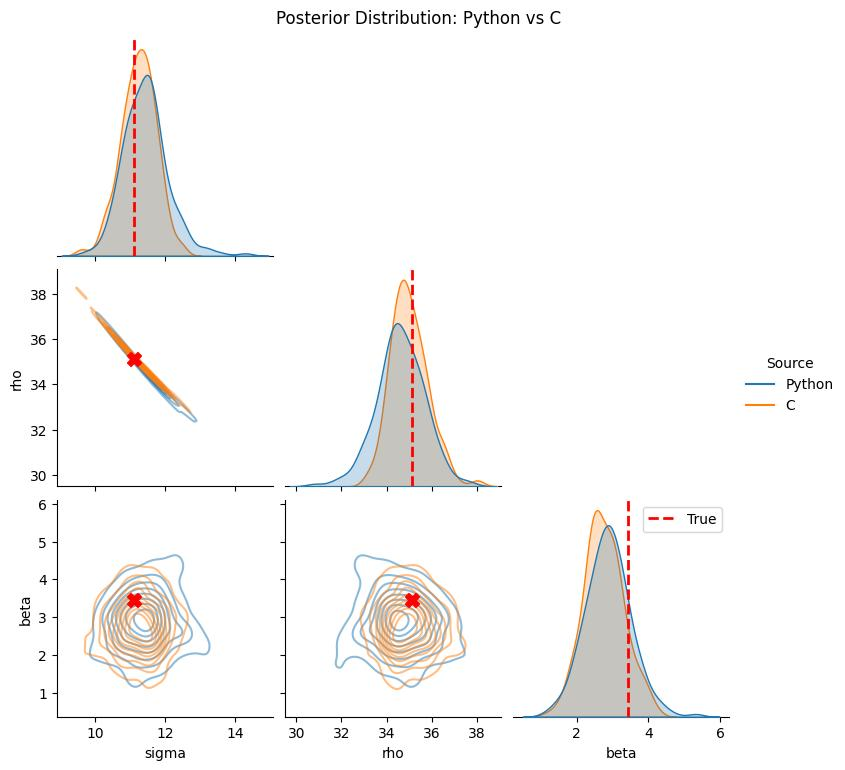

In [5]:
# Select a test sample
test_idx = 0
x_obs_raw = X_test_raw[test_idx].reshape(1, -1)
y_true_raw = Y_test_raw[test_idx]

# Scale features
x_obs = feat_scaler.transform(x_obs_raw)
np.savetxt("tutorial_output/lorenz_test_feat.csv", x_obs, delimiter=",")

# Infer samples
print("Sampling from Lorenz MAF (Python)...")
# x_obs is shape (1, 65). sample() returns (1, 200, 3)
samples_raw = lorenz_maf.sample(x_obs, 200, anp.random.RandomState(42))
samples_scaled = samples_raw[0] # (200, 3)

print("Sampling from Lorenz MAF (C Binary)...")
!time ./smolcde infer --model tutorial_output/lorenz.maf --features tutorial_output/lorenz_test_feat.csv --out tutorial_output/lorenz_samples.csv --mode sample --samples 200

# Load C samples
# Output format: row_idx, sample_idx, p0, p1, p2
df_c_samples = pd.read_csv("tutorial_output/lorenz_samples.csv", names=["row", "sample_idx", "p0", "p1", "p2"], skiprows=1)
samples_c_scaled = df_c_samples[["p0", "p1", "p2"]].values

# Inverse Scale to original domain
samples_py = param_scaler.inverse_transform(samples_scaled)
samples_c = param_scaler.inverse_transform(samples_c_scaled)

# Create combined DataFrame for plotting
df_res_py = pd.DataFrame(samples_py, columns=["sigma", "rho", "beta"])
df_res_py['Source'] = 'Python'
df_res_c = pd.DataFrame(samples_c, columns=["sigma", "rho", "beta"])
df_res_c['Source'] = 'C'

df_res = pd.concat([df_res_py, df_res_c])

# Plot
g = sns.pairplot(df_res, kind="kde", hue="Source", corner=True, plot_kws={'alpha': 0.5})
g.fig.suptitle("Posterior Distribution: Python vs C", y=1.02)

# Overlay true values
true_vals = {'sigma': y_true_raw[0], 'rho': y_true_raw[1], 'beta': y_true_raw[2]}

for i, ax in enumerate(g.diag_axes):
    var = g.x_vars[i]
    ax.axvline(true_vals[var], color='red', linestyle='--', linewidth=2, label='True')

# Off-diagonal
for i, row_var in enumerate(g.y_vars):
    for j, col_var in enumerate(g.x_vars):
        if i > j: # Lower triangle
            ax = g.axes[i, j]
            ax.scatter(true_vals[col_var], true_vals[row_var], color='red', marker='X', s=100, zorder=10)

plt.legend()
plt.savefig("README_lorenz.jpg")

## 2. MNIST Digits Classification

We treat classification as a density estimation problem over the one-hot encoded classes.
- Features: 64 pixels (StandardScaled)
- Params: 10 dimensions (One-Hot Encoded Digit Class)

The model learns $P(\text{class vector} | \text{pixels})$. 
To classify, we infer the mean vector (or samples) and take the `argmax`.


In [6]:
digits = load_digits()
X = digits.data
y = digits.target.reshape(-1, 1)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

enc = OneHotEncoder(sparse_output=False)
Y_train_oh = enc.fit_transform(y_train_raw)
rng = np.random.RandomState(42)
Y_train_noisy = Y_train_oh + rng.normal(0, 0.05, size=Y_train_oh.shape)
param_scaler_mnist = StandardScaler()
Y_train = param_scaler_mnist.fit_transform(Y_train_noisy)

np.savetxt("tutorial_output/mnist_features.csv", X_train, delimiter=",")
np.savetxt("tutorial_output/mnist_params.csv", Y_train, delimiter=",")
np.savetxt("tutorial_output/mnist_test_features.csv", X_test, delimiter=",")

In [7]:
mnist_maf = MAFEstimator(param_dim=10, feature_dim=64, n_flows=6, hidden_units=128)
mnist_maf.train(Y_train, X_train, n_epochs=500, batch_size=64, learning_rate=0.0002)
!time ./smolcde train --features tutorial_output/mnist_features.csv --params tutorial_output/mnist_params.csv --out tutorial_output/mnist.maf --lr 0.0002 --epochs 500 --hidden 128 --blocks 6 --batch 64

samples_mnist = mnist_maf.sample(X_test, 200, anp.random.RandomState(42))  # (N_test, 200, 10)
!time ./smolcde infer --model tutorial_output/mnist.maf --features tutorial_output/mnist_test_features.csv --out tutorial_output/mnist_preds.csv --mode stats --samples 200

Training: 100%|██████████| 500/500 [02:07<00:00,  3.92it/s, train=-6.471, val=56.551] 

Loading data...
Training: 1437 samples, C=64, D=10


Epoch 499: Avg NLL = -5.685326 [################################################# ] 99%
Saved model to tutorial_output/mnist.maf

real	0m33,899s
user	0m33,886s
sys	0m0,004s

real	0m18,685s
user	0m18,680s
sys	0m0,000s


MNIST Accuracy (Python): 97.50%
MNIST Accuracy (C Binary): 97.78%


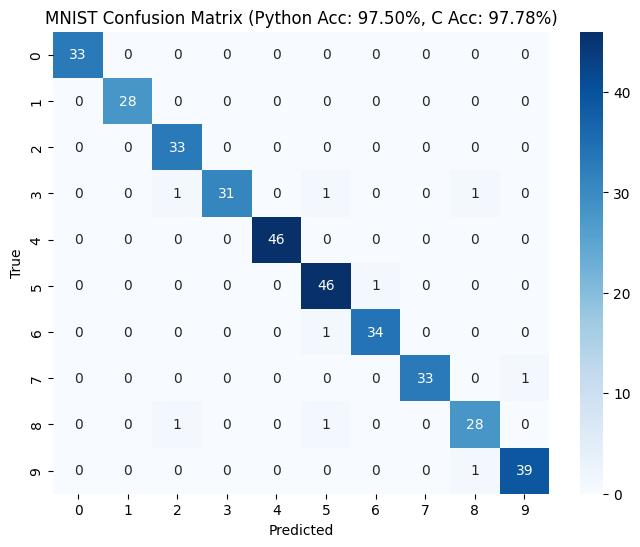

In [8]:
# Python Analysis
pred_vectors_scaled_py = np.mean(samples_mnist, axis=1) # (N_test, 10)
pred_vectors_py = param_scaler_mnist.inverse_transform(pred_vectors_scaled_py)
y_pred_py = np.argmax(pred_vectors_py, axis=1)
y_true = y_test_raw.flatten()
acc_py = np.mean(y_true == y_pred_py)

# C Analysis
# Load predictions. We want rows where stat='mean'
# Output cols: feature_idx, stat, p0...p9
df_preds = pd.read_csv("tutorial_output/mnist_preds.csv")
mean_rows = df_preds[df_preds['stat'] == 'mean'].sort_values('feature_idx')
param_cols = [f'p{i}' for i in range(10)]
pred_vectors_scaled_c = mean_rows[param_cols].values
pred_vectors_c = param_scaler_mnist.inverse_transform(pred_vectors_scaled_c)
y_pred_c = np.argmax(pred_vectors_c, axis=1)
acc_c = np.mean(y_true == y_pred_c)

print(f"MNIST Accuracy (Python): {acc_py:.2%}")
print(f"MNIST Accuracy (C Binary): {acc_c:.2%}")

# Visualize Confusion Matrix
cm = confusion_matrix(y_true, y_pred_py)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'MNIST Confusion Matrix (Python Acc: {acc_py:.2%}, C Acc: {acc_c:.2%})')
plt.savefig("tutorial_output/mnist_confusion.png")